# Music generation using C-RNN-GAN with MIDI network input
Seyed Mohammadsaleh Mirzatabatabaei (smsmt@aut.ac.ir)

Salman Amimotlagh (motlaq@aut.ac.ir)

Aria Espahbodi (aria.esp@aut.ac.ir)

---





![RNN vs DNN t](https://salu133445.github.io/musegan/figs/multitrack1.png)

### Download & Import packages

---

In [ ]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
!pip install music21
!pip install pydub

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icc

In [ ]:
import sys, os, glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from music21 import *
from midi2audio import FluidSynth
from IPython.display import Audio

from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam
from keras import utils

import tensorflow as tf

### MIDI class

---

In [ ]:
class MIDI():
    def __init__(self, seq_length):
        self.seq_length = seq_length
        self.file_rows = []
        self.trainseq = []

    def parser(self, folderName):
        """ Get all the rests and notes and chords from the csv files """

        for file in glob.glob(f"{folderName}/*.csv"):
            print("Parsing %s" % file)
            current_file = []
            with open(file, 'r') as f:
              csvreader = csv.reader(f)
              next(csvreader)  # Skip the header row
              current_file = [[float(value) for value in row[1:]] for row in csvreader] # Don't care about interval column, need floats
              # for row in csvreader:
              #   current_row = []
              #   for value in row[1:]:
              #     current_row.append(float(value))
              #   current_file = [row[1:] for row in csvreader]
            self.file_rows.append(current_file)

    def prepare_sequences(self):
        """ Prepare the sequences used by the Neural Network """

        # create input sequences and the corresponding outputs
        for file in self.file_rows:
            for i in range(len(file) - self.seq_length):
                self.trainseq.append(file[i:i + self.seq_length])

        # Normalize sequences between -1 and 1
        self.trainseq = np.array(self.trainseq)
        self.num_samples, self.sequence_length, self.features = self.trainseq.shape
        print(self.trainseq[0])
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        #self.scaler = StandardScaler()
        self.trainseq = self.trainseq.reshape((self.num_samples, self.sequence_length * self.features))
        print(f"MAX: {np.max(self.trainseq)}")
        #reversed_data = scaler.inverse_transform(normalized_data)

        # Reshape the reversed data back to the original shape
        #reversed_data = reversed_data.reshape((num_samples, sequence_length, features))

        self.trainseq = self.scaler.fit_transform(self.trainseq)
        print(self.trainseq[0])
        return self.trainseq

    def reverse(self, data):
        """ convert the output from the prediction to notes and create a midi file
        from the notes """
        reversed_data = self.scaler.inverse_transform(data)

        #Reshape the reversed data back to the original shape
        return reversed_data.reshape((self.sequence_length, self.features))

### Models summary

---



> **Discriminator**



In [ ]:
discriminator = Sequential()
discriminator.add(LSTM(512, input_shape=(100, 1), return_sequences=True))
discriminator.add(Bidirectional(LSTM(512)))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1052672   
                                                                 
 bidirectional (Bidirection  (None, 1024)              4198400   
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                        



> **Generator**



In [ ]:
generator = Sequential()
generator.add(LSTM(512, input_shape=(1000, 1), return_sequences=True))
generator.add(Bidirectional(LSTM(512)))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(np.prod((100, 1)), activation='tanh'))
generator.add(Reshape((100, 1)))
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1000, 512)         1052672   
                                                                 
 bidirectional_1 (Bidirecti  (None, 1024)              4198400   
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 512)              

### Model class

---

In [ ]:
class MODEL():
  def __init__(self, midi_obj):
    self.midi = midi_obj
    self.seq_length = self.midi.seq_length
    self.seq_shape = (6 * self.seq_length,1)
    self.latent_dim = 1000
    self.disc_loss = []
    self.gen_loss = []

    optimizer = Adam(1e-5, 0.5)

    # Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Build the generator
    self.generator = self.build_generator()

    # The generator takes noise as input and generates note sequences
    z = Input(shape=(self.latent_dim, 1))
    generated_seq = self.generator(z)

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = self.discriminator(generated_seq)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer) # mean_squared_error

  def build_discriminator(self):
    print(self.seq_shape)
    model = Sequential()
    model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    seq = Input(shape=self.seq_shape)
    validity = model(seq)

    return Model(seq, validity)

  def build_generator(self):
    model = Sequential()
    model.add(LSTM(512, input_shape=(self.latent_dim, 1), return_sequences=True))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.seq_shape), activation='relu'))
    model.add(Reshape(self.seq_shape))

    noise = Input(shape=(self.latent_dim, 1))
    seq = model(noise)

    return Model(noise, seq)

  def train(self, epochs, dataFolder, batch_size=128, sample_interval=50):
    # Load and the data
    self.midi.parser(dataFolder)
    sequences = self.midi.prepare_sequences()
    print(sequences.dtype)

    print(f"\nNumber of sequences for train: {sequences.shape[0]}\n")

    # Adversarial ground truths
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Training the model
    for epoch in range(epochs):
      # Training the discriminator
      # Select a random batch of note sequences
      index_seqs = np.random.randint(0, sequences.shape[0], batch_size)
      real_seqs = sequences[index_seqs]

      # Random noise for generator input
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Generate a batch of new note sequences
      gen_seqs = self.generator.predict(noise)
      gen_seqs = tf.squeeze(gen_seqs, axis=-1)
      print(f"{real_seqs.shape}-{gen_seqs.shape}")

      # Train the discriminator
      #try:
      d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
      d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #  Training the Generator
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Train the generator (to have the discriminator label samples as real)
      g_loss = self.combined.train_on_batch(noise, real)

      # Print the progress and save into loss lists
      if epoch % sample_interval == 0:
          print("%d / %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (
          epoch + 1, epochs, d_loss[0], 100 * d_loss[1], g_loss))
          self.disc_loss.append(d_loss[0])
          self.gen_loss.append(g_loss)
      # except Exception as e:
      #   print("FAIL")
      if epoch % 5 == 0:
        print(self.generate())
    self.save()
    print(f"The C-RNN-GAN model has been trained with {dataFolder} csv music,\n" +
          "and saved.")


  def save(self):
    # Get the current timestamp
    now = datetime.datetime.now()

    # Convert the timestamp to a string
    timestamp = str(now.timestamp())

    # create Model directory if there isn't exist
    if not os.path.exists('Model/'):
      os.makedirs('Model/')

    # save discriminator and generator trained model
    self.discriminator.save(f"Model/discriminator-{timestamp}.h5")
    self.generator.save(f"Model/generator-{timestamp}.h5")
    print("The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.")


  def generate(self):
    """ Use random noise to generate music"""

    # random noise for network input
    noise = np.random.normal(0, 1, (1, self.latent_dim))
    prediction = self.generator.predict(noise)
    prediction = tf.squeeze(prediction, axis=-1)
    return self.midi.reverse(prediction)

    # # transfer sequence numbers to notes
    # boundary = int(len(self.midi.transfer_dic) / 2)
    # pred_nums = [x * boundary + boundary for x in predictions[0]]
    # notes = [key for key in self.midi.transfer_dic]
    # pred_notes = [notes[int(x) % len(notes)] for x in pred_nums] # % len(notes)

    # # create Result directory if there isn't exist
    # if not os.path.exists('Result/'):
    #   os.makedirs('Result/')

    # # generate music with .midi format
    # self.midi.create_midi(pred_notes, 'Result/gan_final')


  def plot_loss(self):
    """ Plot and save discriminator and generator loss functions per epoch diagram"""
    plt.plot(self.disc_loss, c='red')
    plt.plot(self.gen_loss, c='blue')
    plt.title("GAN Loss per Epoch")
    plt.legend(['Discriminator', 'Generator'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.savefig('Result/GAN_Loss_per_Epoch_final.png', transparent=True)
    plt.close()

In [ ]:
midi = MIDI(seq_length=16)
model = MODEL(midi_obj=midi)
model.train(20, dataFolder='music', batch_size=64, sample_interval=2)

(192, 1)
Parsing music/6.csv
Parsing music/7.csv
Parsing music/8.csv
Parsing music/9.csv
Parsing music/4 Emin 70.csv
Parsing music/3.csv
Parsing music/5.csv
Parsing music/1.csv
Parsing music/5 Bmin 70.csv
Parsing music/test1-jazz.csv
Parsing music/1 Cmin 70.csv
Parsing music/2 C#min 70 bpm.csv
Parsing music/long_generated_1.csv
Parsing music/10.csv
Parsing music/3 Cmin 70.csv
Parsing music/2.csv
Parsing music/4.csv
[[  330.           990.           660.         17412.75131815
  27550.08500757 28286.96634527]
 [  990.           330.           660.         16412.28334266
  19100.7776229  23297.03067157]
 [  655.           330.           245.          9705.67915142
  17730.63018329 20451.49999001]
 [  245.           660.           390.         16367.52323031
  20953.90822949 24301.17364353]
 [  660.           245.           390.         13432.45165112
  17942.6664652  26456.44796809]
 [  660.           245.           390.         11179.86993419
  17093.92595953 26941.42937667]
 [  395.   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.
The C-RNN-GAN model has been trained with music csv music,
and saved.


### Save Model

---

In [ ]:
model.save()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.


### Generate Music

---

In [ ]:
# ONLY IF YOU NEED TO RELOAD THE MODEL

# import keras
# midi = MIDI(seq_length=16)
# model = MODEL(midi_obj=midi)
# model.midi.parser("data2")
# model.midi.prepare_sequences()
# model.generator = keras.models.load_model('Model/generator.h5')

Parsing data2/5 Bmin 70.mid
Parsing data2/UNISON_MELODYLOOP_Beep - Piano (174 BPM - F#m).mid
Parsing data2/UNISON_MELODYLOOP_Player One - Synth Pluck (166  BPM - Ebm).mid
Parsing data2/UNISON_MELODYLOOP_Daytons - Synth Stab (104 BPM - Bbm).mid
Parsing data2/UNISON_MELODYLOOP_Icebox - Piano (184 BPM - Dm).mid
Parsing data2/UNISON_MELODYLOOP_Ice Cold - Strings (128 BPM - Cm).mid
Parsing data2/UNISON_MELODYLOOP_Rollin - Pluck 2 (160 BPM - Cm).mid
Parsing data2/UNISON_MELODYLOOP_Player One - Theremin (166 BPM - Ebm).mid
Parsing data2/UNISON_MELODYLOOP_Queen St - Bass (140 BPM - Gm).mid
Parsing data2/UNISON_MELODYLOOP_Beep - Guitar (174 BPM - F#m).mid
Parsing data2/UNISON_MELODYLOOP_Daytons - Bass (104 BPM - Bbm).mid
Parsing data2/UNISON_MELODYLOOP_Pyramids - Bass (106 BPM - Em).mid
Parsing data2/UNISON_MELODYLOOP_Don't Be Mad - Pluck (101 BPM - Cm).mid
Parsing data2/UNISON_MELODYLOOP_Icebox - Guitar (184 BPM - Dm).mid
Parsing data2/UNISON_MELODYLOOP_Daytons - Rhodes (104 BPM - Bbm).mid
Par

In [ ]:
def get_frequencies_amplitudes(values):
  return values[:4], values[4:]
def write_results(values):
    # Create an empty audio segment

    filename = "output.csv"
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Interval', 'Frequency', 'Volume'])
        for i, row in enumerate(values):
          top_frequencies, top_amplitudes = row[:4], row[4:]
          # print(f"Interval {i + 1}:")
          csv_row = [i]
          csv_row.extend(top_frequencies)
          csv_row.extend(top_amplitudes)
          csvwriter.writerow(csv_row)


In [ ]:
predictions = model.generate()
print(predictions)
model.save()

1/1 [==============================] - 2s 2s/step
[[2.35024944e+04 2.35000000e+02 2.45000000e+02 4.24191403e+03
  1.26223976e+06 1.26016895e+06]
 [2.30000000e+02 4.86692193e+03 2.45000000e+02 4.24191403e+03
  4.75633360e+03 7.46176880e+03]
 [2.30000000e+02 2.35000000e+02 2.45000000e+02 4.24191403e+03
  2.80544455e+05 7.46176880e+03]
 [2.30000000e+02 2.35000000e+02 2.45000000e+02 4.24191403e+03
  4.75633360e+03 7.46176880e+03]
 [8.53898172e+02 2.35000000e+02 2.72752669e+03 6.54510100e+04
  8.59123793e+04 7.46176880e+03]
 [2.30000000e+02 2.35000000e+02 2.45000000e+02 4.24191403e+03
  4.75633360e+03 7.46176880e+03]
 [2.30000000e+02 1.35370965e+03 2.50000000e+02 1.83907354e+05
  1.67033592e+05 7.46176880e+03]
 [2.30000000e+02 2.35000000e+02 2.50000000e+02 4.24191403e+03
  4.75633360e+03 7.46176880e+03]
 [2.30000000e+02 2.35000000e+02 2.50000000e+02 2.43392965e+05
  4.75633360e+03 7.24686776e+04]
 [7.44191109e+03 2.35000000e+02 2.50000000e+02 1.50970217e+04
  4.75633360e+03 7.46176880e+03]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.


In [ ]:
!pip install pydub

In [ ]:
write_results(predictions)

In [ ]:
import csv
from pydub import AudioSegment
from pydub.generators import Sine

def build_audio(interval_duration):
    filename = "output.csv"
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        num_rows = len(list(reader))
    # Create an empty audio segment
    output_audio = AudioSegment.silent(duration=1000 * interval_duration * num_rows)

    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip the header row

        i = 1
        for row in csvreader:
            frequencies = [float(x) for x in row[1:4]]
            volumes = [float(x) for x in row[4:]]


            for freq, amp in zip(frequencies, volumes):
                sine_wave = Sine(freq)
                sine_wave = sine_wave.to_audio_segment(duration=1000 * interval_duration)
                sine_wave = sine_wave - (60 - amp / 15000 * 25)  # Adjust volume
                output_audio = output_audio.overlay(sine_wave, position=i * 1000 * interval_duration)
                # print(f"  Frequency: {freq} Hz, Amplitude: {amp}")
            i +=1

    # Increase the overall volume
    volume_scaling = 0  # Adjust as needed
    output_audio = output_audio + volume_scaling

    # Export the resulting audio to a WAV file
    output_file_path = 'test_construct.wav'
    output_audio.export(output_file_path, format='wav')


# Set the desired interval duration in seconds
interval_duration = 0.2

build_audio(interval_duration)


In [ ]:
!fluidsynth -ni font.sf2 Result/gan_final.mid -F Result/output.wav -r 44100

sound_file = './Result/output.wav'
Audio(sound_file)

FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'Result/output.wav'..


### Model loss function

---

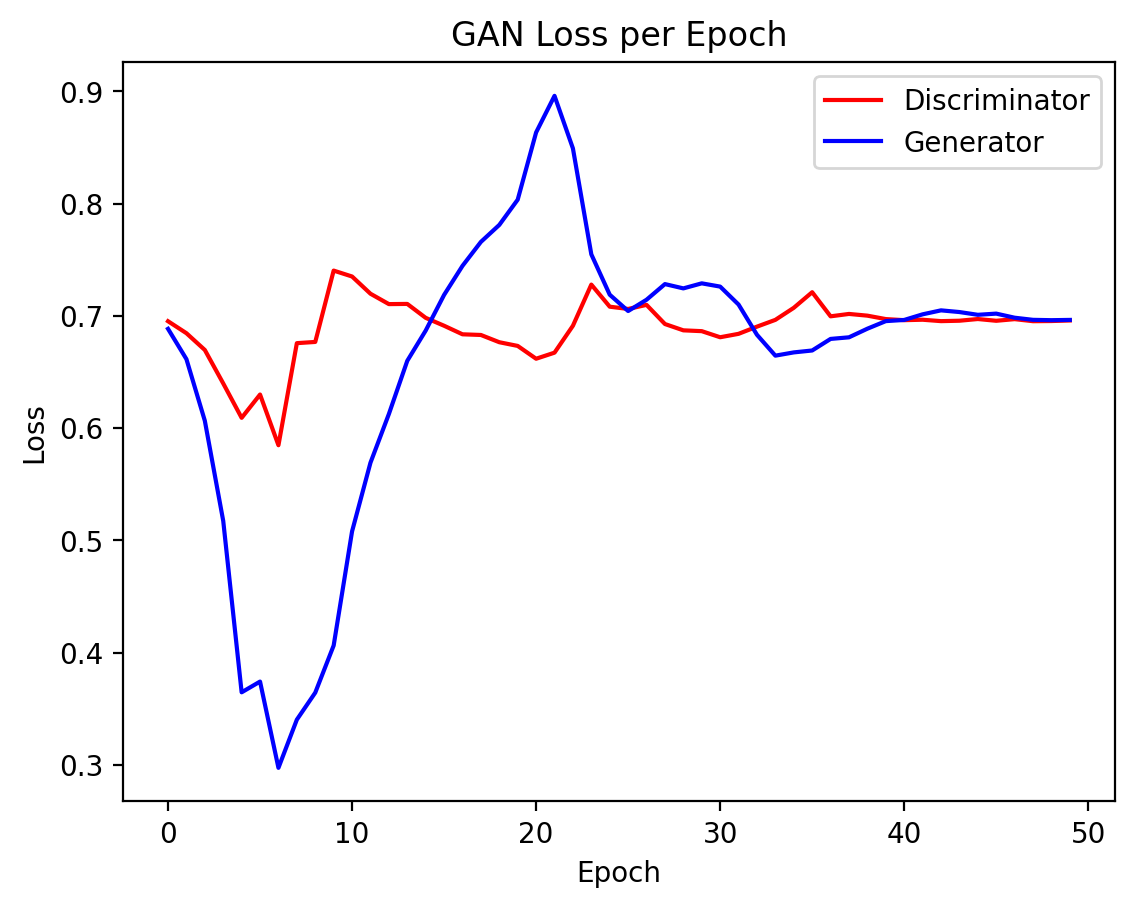

In [ ]:
model.plot_loss()